In [420]:
# Import Necessary Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# Load the dataset from a local file (adjust path as needed)
file_path = "student-mat.csv"  # Replace with the correct file path
df = pd.read_csv(file_path, sep=";")

# Preview the dataset
print(df.head())  # Display the first few rows of the dataset
print(df.info())  # Show a summary of the dataset (data types, non-null counts)




  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (to

In [421]:
#  Data Cleaning
print("Initial dataset shape:", df.shape)


Initial dataset shape: (395, 33)


In [422]:
# Handling missing values
df = df.dropna()  # Drop rows with missing values
print("After removing missing values:", df.shape)




After removing missing values: (395, 33)


In [423]:
# Removing duplicates
df = df.drop_duplicates()
print("After removing duplicates:", df.shape)

After removing duplicates: (395, 33)


In [424]:
# Data Categorization (Convert final grade into categories)
def categorize_grade(grade):
    if grade >= 15:
        return 'High'  # Good students
    elif 10 <= grade < 15:
        return 'Medium'  # Average students
    else:
        return 'Low'  # Weak students

df['Performance'] = df['G3'].apply(categorize_grade)


In [425]:

# Define the path where the label encoder will be saved (models directory)
MODEL_DIR = os.path.join(os.getcwd(), 'models')  # Change to the appropriate models directory
label_encoder_path = os.path.join(MODEL_DIR, 'label_encoder')

In [426]:
# Create the models directory if it doesn't exist
os.makedirs(MODEL_DIR, exist_ok=True)

In [427]:
# Assuming you have a dataframe `df` with your target column
label_encoder = LabelEncoder()

In [428]:
#  Fit the label encoder on the target values (e.g., 'High', 'Medium', 'Low')
df['Performance'] = label_encoder.fit_transform(df['Performance'])

In [429]:
# Save the trained label encoder
joblib.dump(label_encoder, label_encoder_path)
print(f"✅ Label encoder saved successfully to {label_encoder_path}.")

✅ Label encoder saved successfully to c:\Users\nkwet\Desktop\student performance pred\student_performance\models\label_encoder.


In [430]:
# Feature Engineering
df['avg_grade'] = df[['G1', 'G2']].mean(axis=1)

In [431]:
# Define Features and Target
features = ['G1', 'G2', 'studytime', 'absences', 'avg_grade']
target = 'Performance'

In [432]:
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['number'])

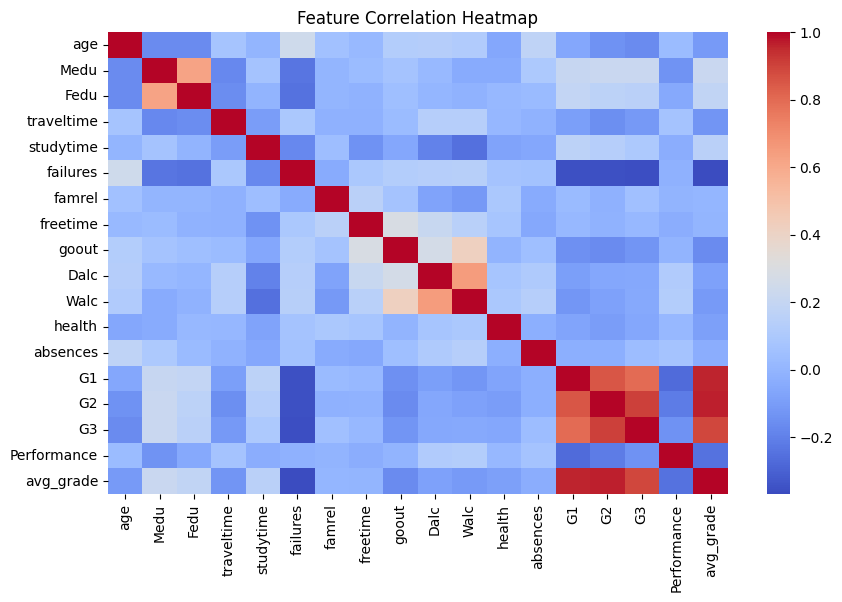

In [433]:

# Visualize correlation
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=False, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

In [434]:
# Prepare directories
MODEL_DIR = os.path.join(os.getcwd(), "models")
os.makedirs(MODEL_DIR, exist_ok=True)

In [435]:
# File paths
MODEL_PATH = os.path.join(MODEL_DIR, "random_forest_model")
FEATURES_PATH = os.path.join(MODEL_DIR, "feature_names")
SCALER_PATH = os.path.join(MODEL_DIR, "scaler")

In [436]:
# Prepare Data
X = df[features]
y = df[target]

In [437]:
# Split Data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [438]:
# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [439]:
# Hyperparameter Tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 5, 10, 15],  # Tree depth
    'min_samples_split': [2, 5, 10]  # Minimum samples per split
}

In [440]:
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 15],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [441]:
# Best Model
best_model = grid_search.best_estimator_
print(f"✅ Best Model Parameters: {grid_search.best_params_}")

✅ Best Model Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}


In [442]:
# Save Model, Features, and Scaler
joblib.dump(best_model, MODEL_PATH)
joblib.dump(features, FEATURES_PATH)
joblib.dump(scaler, SCALER_PATH)

['c:\\Users\\nkwet\\Desktop\\student performance pred\\student_performance\\models\\scaler']

In [443]:
# Load the trained model and feature names for testing
clf = joblib.load(MODEL_PATH)
loaded_features = joblib.load(FEATURES_PATH)
scaler = joblib.load(SCALER_PATH)

In [444]:
# Convert test data to DataFrame with correct feature names
X_test_df = pd.DataFrame(X_test_scaled, columns=loaded_features)

In [445]:
# Predict on test data
y_pred = clf.predict(X_test_df)

c:\Users\nkwet\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [ ]:
# Ensure prediction outputs are correct
accuracy = accuracy_score(y_test, y_pred)
print(f"\n🔹 Model Accuracy: {accuracy:.2f}\n")
print("🔹 Classification Report:\n", classification_report(y_test, y_pred))



🔹 Model Accuracy: 0.87

🔹 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.85      0.92        20
           1       0.86      0.89      0.87        27
           2       0.82      0.88      0.85        32

    accuracy                           0.87        79
   macro avg       0.89      0.87      0.88        79
weighted avg       0.88      0.87      0.87        79



In [ ]:
# Evaluate Model Performance
accuracy = accuracy_score(y_test, y_pred)
print(f"\n🔹 Model Accuracy: {accuracy:.2f}\n")


🔹 Model Accuracy: 0.87



In [ ]:
# Classification Report
print("🔹 Classification Report:\n", classification_report(y_test, y_pred))

🔹 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.85      0.92        20
           1       0.86      0.89      0.87        27
           2       0.82      0.88      0.85        32

    accuracy                           0.87        79
   macro avg       0.89      0.87      0.88        79
weighted avg       0.88      0.87      0.87        79



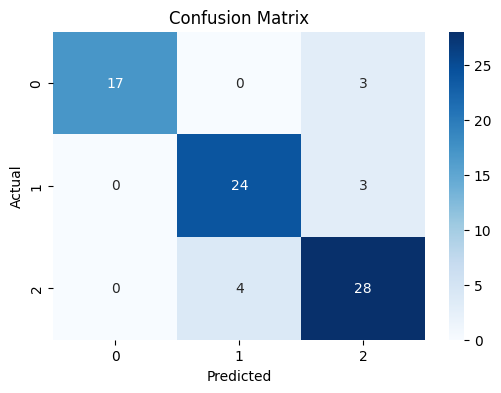

In [ ]:

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

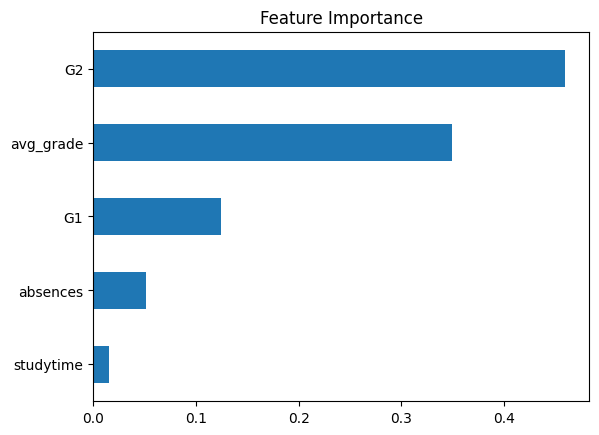

In [ ]:
# Feature Importance
feature_importance = pd.Series(clf.feature_importances_, index=features)
feature_importance.sort_values().plot(kind="barh", title="Feature Importance")
plt.show()

In [ ]:
# Debugging: Print loaded feature names
print("✅ Loaded Model Feature Names:", getattr(clf, "feature_names_in_", "No feature names found"))
print("✅ Loaded Features from File:", loaded_features)

✅ Loaded Model Feature Names: No feature names found
✅ Loaded Features from File: ['G1', 'G2', 'studytime', 'absences', 'avg_grade']


In [ ]:
test_samples = [
    [10, 12, 3, 2, 11],  # Medium performer
    [16, 17, 2, 1, 16.5],  # High performer
    [5, 6, 1, 10, 5.5]  # Low performer
]


In [ ]:
test_df = pd.DataFrame(test_samples, columns=features)
test_df_scaled = scaler.transform(test_df)

In [ ]:
# Predict for sample cases
predictions = clf.predict(test_df_scaled)
for i, sample in enumerate(test_samples):
    print(f"🔹 Input: {sample} → Predicted Performance: {predictions[i]}")

🔹 Input: [10, 12, 3, 2, 11] → Predicted Performance: 2
🔹 Input: [16, 17, 2, 1, 16.5] → Predicted Performance: 0
🔹 Input: [5, 6, 1, 10, 5.5] → Predicted Performance: 1


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\n🔹 Model Accuracy: {accuracy:.2f}\n")



🔹 Model Accuracy: 0.87



In [ ]:
# Train and Test Accuracy
train_accuracy = clf.score(X_train_scaled, y_train)  # Accuracy on training data
test_accuracy = clf.score(X_test_scaled, y_test)  # Accuracy on test data

print(f"🔹 Train Accuracy: {train_accuracy:.2f}")
print(f"🔹 Test Accuracy: {test_accuracy:.2f}")



🔹 Train Accuracy: 0.94
🔹 Test Accuracy: 0.87


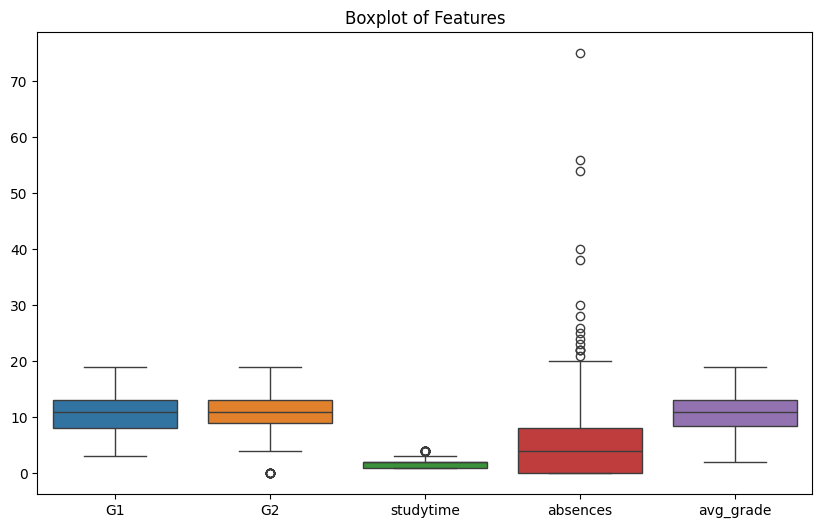

In [ ]:
# Plot boxplot to detect outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[features])
plt.title("Boxplot of Features")
plt.show()


In [ ]:
# Remove rows where absences is greater than 100
df = df[df['absences'] < 100]



In [ ]:
# Check for class imbalance
print(df[target].value_counts())

Performance
2    192
1    130
0     73
Name: count, dtype: int64


In [ ]:
# If imbalance is found, use SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

In [ ]:
# Re-train the model with resampled data
clf.fit(X_train_res, y_train_res)

RandomForestClassifier(class_weight='balanced', min_samples_split=5,
                       n_estimators=50, random_state=42)

In [ ]:
# Check accuracy and other metrics again
y_pred = clf.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.89
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        20
           1       0.89      0.89      0.89        27
           2       0.83      0.91      0.87        32

    accuracy                           0.89        79
   macro avg       0.91      0.88      0.89        79
weighted avg       0.89      0.89      0.89        79

